<a href="https://colab.research.google.com/github/L-Lush/LLaVA/blob/main/LLaVA_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLaVA Chatbot

This notebook shows how to create a chatbot with the [multimodal LLaVA model](https://llava-vl.github.io/). See the [related blog post for context](https://medium.com/p/b06f88ce8efa).

The notebook is divided in two parts:

- Load a LLaVA model and make it generate an answer from an image and a prompt

- Create a LLaVA chatbot interface using Gradio

The notebook can be run using Google Colab and a T4 TPU.


## Setting up environment

We rely on

- the transformers, bitsandbytes and accelerate libraries for loading/running the LLaVA model
- the gradio library for creating the Web chatbot interface

Note: if you get the bug 'A UTF-8 locale is required. Got ANSI_X3.4-1968', try running the following code:

```
import locale
locale.getpreferredencoding = lambda: "UTF-8"
```

In [ ]:
!pip install -q transformers==4.36.0
!pip install -q bitsandbytes==0.41.3 accelerate==0.25.0
!pip install -q gradio==4.14.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.1/305.1 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 13.4 

## Load the LLaVA model

The model is loaded from its [HuggingFace repository](https://huggingface.co/llava-hf/llava-1.5-7b-hf), using the transformers' `pipeline` object.

Let us quantize it in 4bits to reduce the GPU memory consumption.

In [ ]:
from transformers import pipeline, BitsAndBytesConfig
import torch

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

# 13B version can be loaded with llava-hf/llava-1.5-13b-hf
model_id = "llava-hf/llava-1.5-7b-hf"


pipe = pipeline("image-to-text", model=model_id, model_kwargs={"quantization_config": quantization_config})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/954 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


preprocessor_config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

### Test LLaVA model

Let us load the following image (Image by <a href="https://pixabay.com/users/grey48-7109111/?utm_source=link-attribution&utm_medium=referral&utm_campaign=image&utm_content=3116211">Guy Rey-Bellet</a> from <a href="https://pixabay.com//?utm_source=link-attribution&utm_medium=referral&utm_campaign=image&utm_content=3116211">Pixabay</a>)

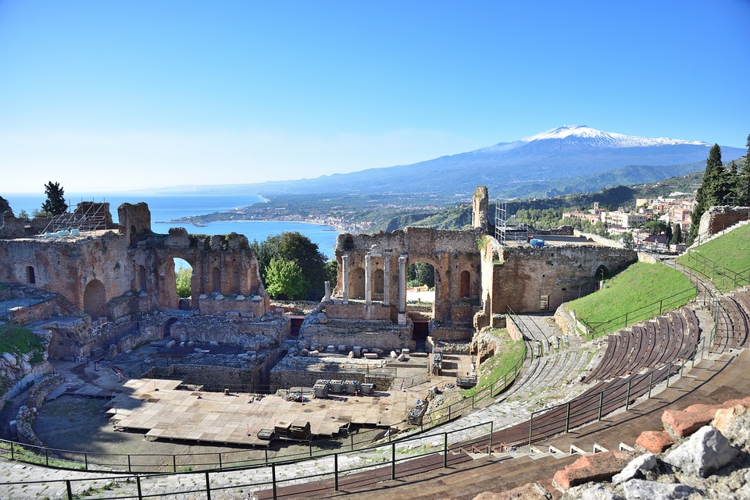

In [ ]:
import requests
from PIL import Image

image_url = "https://cdn.pixabay.com/photo/2018/01/29/14/13/italy-3116211_960_720.jpg"

image = Image.open(requests.get(image_url, stream=True).raw).resize((750,500))
image

In [ ]:
prompt = "USER: <image>\nDescribe this picture\n​ASSISTANT: "

outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})
print(outputs[0]['generated_text'])

USER:  
Describe this picture
​ASSISTANT: ​The image features a large, empty amphitheater with a stunning view of the ocean in the background. The amphitheater is surrounded by a lush green hillside, and a majestic mountain can be seen in the distance. The scene is serene and picturesque, with the sun shining brightly over the landscape.


# Create a LLaVA chatbot with Gradio


In [ ]:
def update_conversation(new_message, history, image):

    if image is None:
        return "Please upload an image first using the widget on the left"

    conversation_starting_from_image = [[user, assistant] for [user, assistant] in history if not assistant.startswith('Please')]

    prompt = "USER: <image>\n"

    for i in range(len(history)):
        prompt+=history[i][0]+'\nASSISTANT: '+history[i][1]+"\nUSER: "

    prompt = prompt+new_message+'\nASSISTANT: '

    outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200
                                                          #, "do_sample" : True,
                                                          #"temperature" : 0.7
                                                          })[0]['generated_text']

    return outputs[len(prompt)-6:]


In [ ]:
import gradio as gr

with gr.Blocks() as demo:

    with gr.Row():
      image = gr.Image(type='pil', interactive=True)

      gr.ChatInterface(
          update_conversation, additional_inputs=[image]
      )

demo.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://276cc7d99ca1ac57df.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://276cc7d99ca1ac57df.gradio.live


Related notebooks:

- Loading LLaVA in 4bits with colab: https://colab.research.google.com/drive/1qsl6cd2c8gGtEW1xV5io7S8NHh-Cp1TV?usp=sharing (from official transformers library at https://huggingface.co/docs/transformers/model_doc/llava)

